<a href="https://colab.research.google.com/github/pburnham50/FateTrack/blob/main/FateTrack_Processing_Current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Here we show give an example of our full pipeline to extract data from timelapse.

### Load all relevant packages and connecting to your Drive


In [ ]:
#@markdown #### Mount google drive and check that you are using high RAM and GPU resources.

from google.colab import drive
drive.mount('/content/drive')

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!
Wed Oct 20 23:49:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--

In [ ]:
%%capture

Notebook_version = ['1.12']

#@markdown ####Install packages related to CARE

#Libraries contains information of certain topics. 
#For example the tifffile library contains information on how to handle tif-files.

#Here, we install libraries which are not already included in Colab.

!pip install tifffile # contains tools to operate tiff-files
!pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
!pip install wget
!pip install memory_profiler
!pip install fpdf
!pip install scikit-image==0.18
%load_ext memory_profiler

#Here, we import and enable Tensorflow 1 instead of Tensorflow 2.
%tensorflow_version 1.x

import sys
before = [str(m) for m in sys.modules]

import tensorflow 
import tensorflow as tf

print(tensorflow.__version__)
print("Tensorflow enabled.")

# ------- Variable specific to CARE -------
from csbdeep.utils import download_and_extract_zip_file, plot_some, axes_dict, plot_history, Path, download_and_extract_zip_file
from csbdeep.data import RawData, create_patches 
from csbdeep.io import load_training_data, save_tiff_imagej_compatible
from csbdeep.models import Config, CARE
from csbdeep import data
from __future__ import print_function, unicode_literals, absolute_import, division
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



# ------- Common variable to all ZeroCostDL4Mic notebooks -------
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave
import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32
from skimage.util import img_as_ubyte
from tqdm import tqdm 
from fpdf import FPDF, HTMLMixin
from datetime import datetime
import subprocess
from pip._internal.operations.freeze import freeze

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print("Libraries installed")


# Check if this is the latest version of the notebook
Latest_notebook_version = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_ZeroCostDL4Mic_Release.csv")

if Notebook_version == list(Latest_notebook_version.columns):
  print("This notebook is up-to-date.")

if not Notebook_version == list(Latest_notebook_version.columns):
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")

!pip freeze > requirements.txt

#Create a pdf document with training summary

def pdf_export(trained = False, augmentation = False, pretrained_model = False):
    # save FPDF() class into a  
    # variable pdf 
    #from datetime import datetime

    class MyFPDF(FPDF, HTMLMixin):
        pass

    pdf = MyFPDF()
    pdf.add_page()
    pdf.set_right_margin(-1)
    pdf.set_font("Arial", size = 11, style='B') 

    Network = 'CARE 2D'
    day = datetime.now()
    datetime_str = str(day)[0:10]

    Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
    pdf.multi_cell(180, 5, txt = Header, align = 'L') 

    # add another cell 
    if trained:
      training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
      pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
    pdf.ln(1)

    Header_2 = 'Information for your materials and methods:'
    pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

    all_packages = ''
    for requirement in freeze(local_only=True):
      all_packages = all_packages+requirement+', '
    #print(all_packages)

    #Main Packages
    main_packages = ''
    version_numbers = []
    for name in ['tensorflow','numpy','Keras','csbdeep']:
      find_name=all_packages.find(name)
      main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
      #Version numbers only here:
      version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

    cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
    cuda_version = cuda_version.stdout.decode('utf-8')
    cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
    gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
    gpu_name = gpu_name.stdout.decode('utf-8')
    gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
    #print(cuda_version[cuda_version.find(', V')+3:-1])
    #print(gpu_name)

    shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
    dataset_size = len(os.listdir(Training_source))

    text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(dataset_size*number_of_patches)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+config.train_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

    if pretrained_model:
      text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(dataset_size*number_of_patches)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+config.train_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was re-trained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

    pdf.set_font('')
    pdf.set_font_size(10.)
    pdf.multi_cell(190, 5, txt = text, align='L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.ln(1)
    pdf.cell(28, 5, txt='Augmentation: ', ln=0)
    pdf.set_font('')
    if augmentation:
      aug_text = 'The dataset was augmented by a factor of '+str(Multiply_dataset_by)+' by'
      if rotate_270_degrees != 0 or rotate_90_degrees != 0:
        aug_text = aug_text+'\n- rotation'
      if flip_left_right != 0 or flip_top_bottom != 0:
        aug_text = aug_text+'\n- flipping'
      if random_zoom_magnification != 0:
        aug_text = aug_text+'\n- random zoom magnification'
      if random_distortion != 0:
        aug_text = aug_text+'\n- random distortion'
      if image_shear != 0:
        aug_text = aug_text+'\n- image shearing'
      if skew_image != 0:
        aug_text = aug_text+'\n- image skewing'
    else:
      aug_text = 'No augmentation was used for training.'
    pdf.multi_cell(190, 5, txt=aug_text, align='L')
    pdf.set_font('Arial', size = 11, style = 'B')
    pdf.ln(1)
    pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font_size(10.)
    if Use_Default_Advanced_Parameters:
      pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
    pdf.cell(200, 5, txt='The following parameters were used for training:')
    pdf.ln(1)
    html = """ 
    <table width=40% style="margin-left:0px;">
      <tr>
        <th width = 50% align="left">Parameter</th>
        <th width = 50% align="left">Value</th>
      </tr>
      <tr>
        <td width = 50%>number_of_epochs</td>
        <td width = 50%>{0}</td>
      </tr>
      <tr>
        <td width = 50%>patch_size</td>
        <td width = 50%>{1}</td>
      </tr>
      <tr>
        <td width = 50%>number_of_patches</td>
        <td width = 50%>{2}</td>
      </tr>
      <tr>
        <td width = 50%>batch_size</td>
        <td width = 50%>{3}</td>
      </tr>
      <tr>
        <td width = 50%>number_of_steps</td>
        <td width = 50%>{4}</td>
      </tr>
      <tr>
        <td width = 50%>percentage_validation</td>
        <td width = 50%>{5}</td>
      </tr>
      <tr>
        <td width = 50%>initial_learning_rate</td>
        <td width = 50%>{6}</td>
      </tr>
    </table>
    """.format(number_of_epochs,str(patch_size)+'x'+str(patch_size),number_of_patches,batch_size,number_of_steps,percentage_validation,initial_learning_rate)
    pdf.write_html(html)

    #pdf.multi_cell(190, 5, txt = text_2, align='L')
    pdf.set_font("Arial", size = 11, style='B')
    pdf.ln(1)
    pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(29, 5, txt= 'Training_source:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(27, 5, txt= 'Training_target:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
    #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
    pdf.ln(1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(22, 5, txt= 'Model Path:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
    pdf.ln(1)
    pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
    pdf.ln(1)
    exp_size = io.imread('/content/TrainingDataExample_CARE2D.png').shape
    pdf.image('/content/TrainingDataExample_CARE2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
    pdf.ln(1)
    ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
    pdf.multi_cell(190, 5, txt = ref_1, align='L')
    ref_2 = '- CARE: Weigert, Martin, et al. "Content-aware image restoration: pushing the limits of fluorescence microscopy." Nature methods 15.12 (2018): 1090-1097.'
    pdf.multi_cell(190, 5, txt = ref_2, align='L')
    if augmentation:
      ref_3 = '- Augmentor: Bloice, Marcus D., Christof Stocker, and Andreas Holzinger. "Augmentor: an image augmentation library for machine learning." arXiv preprint arXiv:1708.04680 (2017).'
      pdf.multi_cell(190, 5, txt = ref_3, align='L')
    pdf.ln(3)
    reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
    pdf.set_font('Arial', size = 11, style='B')
    pdf.multi_cell(190, 5, txt=reminder, align='C')

    pdf.output(model_path+'/'+model_name+'/'+model_name+"_training_report.pdf")


#Make a pdf summary of the QC results

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'CARE 2D'
  #model_name = os.path.basename(full_QC_model_path)
  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  if os.path.exists(full_QC_model_path+'Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/13))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.', align='L')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier New" >
  <table width=94% style="margin-left:0px;">"""
  with open(full_QC_model_path+'Quality Control/QC_metrics_'+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    image = header[0]
    mSSIM_PvsGT = header[1]
    mSSIM_SvsGT = header[2]
    NRMSE_PvsGT = header[3]
    NRMSE_SvsGT = header[4]
    PSNR_PvsGT = header[5]
    PSNR_SvsGT = header[6]
    header = """
    <tr>
      <th width = 10% align="left">{0}</th>
      <th width = 15% align="left">{1}</th>
      <th width = 15% align="center">{2}</th>
      <th width = 15% align="left">{3}</th>
      <th width = 15% align="center">{4}</th>
      <th width = 15% align="left">{5}</th>
      <th width = 15% align="center">{6}</th>
    </tr>""".format(image,mSSIM_PvsGT,mSSIM_SvsGT,NRMSE_PvsGT,NRMSE_SvsGT,PSNR_PvsGT,PSNR_SvsGT)
    html = html+header
    for row in metrics:
      image = row[0]
      mSSIM_PvsGT = row[1]
      mSSIM_SvsGT = row[2]
      NRMSE_PvsGT = row[3]
      NRMSE_SvsGT = row[4]
      PSNR_PvsGT = row[5]
      PSNR_SvsGT = row[6]
      cells = """
        <tr>
          <td width = 10% align="left">{0}</td>
          <td width = 15% align="center">{1}</td>
          <td width = 15% align="center">{2}</td>
          <td width = 15% align="center">{3}</td>
          <td width = 15% align="center">{4}</td>
          <td width = 15% align="center">{5}</td>
          <td width = 15% align="center">{6}</td>
        </tr>""".format(image,str(round(float(mSSIM_PvsGT),3)),str(round(float(mSSIM_SvsGT),3)),str(round(float(NRMSE_PvsGT),3)),str(round(float(NRMSE_SvsGT),3)),str(round(float(PSNR_PvsGT),3)),str(round(float(PSNR_SvsGT),3)))
      html = html+cells
    html = html+"""</body></table>"""

  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- CARE: Weigert, Martin, et al. "Content-aware image restoration: pushing the limits of fluorescence microscopy." Nature methods 15.12 (2018): 1090-1097.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(full_QC_model_path+'Quality Control/'+QC_model_name+'_QC_report.pdf')


# Exporting requirements.txt for local run
!pip freeze > requirements.txt

after = [str(m) for m in sys.modules]
# Get minimum requirements file

#Add the following lines before all imports: 
#  import sys
#  before = [str(m) for m in sys.modules]

#Add the following line after the imports:
#  after = [str(m) for m in sys.modules]

from builtins import any as b_any

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

df = pd.read_csv('requirements.txt', delimiter = "\n")
mod_list = [m.split('.')[0] for m in after if not m in before]
req_list_temp = df.values.tolist()
req_list = [x[0] for x in req_list_temp]

# Replace with package name 
mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
filtered_list = filter_files(req_list, mod_replace_list)


file=open('CARE_2D_requirements_simple.txt','w')
for item in filtered_list:
    file.writelines(item + '\n')

file.close()

import pandas as pd
from skimage import io,exposure, util
import matplotlib as plt
import numpy as np
!pip install cellpose 
from cellpose import models,io
use_GPU = models.use_gpu()
from cellpose import plot

In [ ]:
#@markdown ####Load all other packages and general functions
%%capture
!pip install mahotas
!pip install ortools
!pip install nd2reader
from scipy import ndimage as ndi
from skimage import color, feature, filters, io, measure, morphology, restoration, segmentation, exposure, restoration, data, exposure
import warnings
from skimage.feature import greycomatrix, greycoprops
from numpy import genfromtxt
from skimage.segmentation import clear_border
import mahotas
from skimage.feature import hog
import dill
import nd2reader
import sys
sys.path.insert(0,"/content/drive/MyDrive/FateTrack_master/FateTrackScripts/")
from FT_connect_functions import *
import matplotlib.pyplot as plt
from skimage import morphology,transform

from scipy import ndimage as ndi
import cv2
from functools import reduce

# list of all features that are calculated using scikit image
featureColumns = ('label','area','filled_area','bbox','bbox_area', 'centroid','convex_area','eccentricity',
                      'solidity','convex_area','mean_intensity','min_intensity','filled_area',
                      'max_intensity','orientation','major_axis_length','minor_axis_length','euler_number',
                      'perimeter','extent','equivalent_diameter','feret_diameter_max','perimeter_crofton',
                      'moments_central','moments_hu','moments','moments_normalized',
                      'inertia_tensor','inertia_tensor_eigvals')

####!!!!####

# collect all features from a segmentation mask.
# specify the segmentation mask and channel-based Image (will calculate fluoresence features as well).
def collectObjectTraits(segmentationsMask, channelImage,prefix="", time=0, addExtras=False, maxsize=100):

    image_props = pd.DataFrame(measure.regionprops_table(segmentationsMask, intensity_image=channelImage,properties=featureColumns)) # generate standard measurements with properties listed above.
    im_df = pd.DataFrame(image_props) # convert object to dataframe  

    # extra features are added below (if specified)
    if (addExtras):
      additionProps = pd.DataFrame() # set up dataframe

      for object in range(im_df.shape[0]):
          tmpProps = extraObjectTraits(im_df['intensity_image'][object],maxsize=maxsize) # performs extra measurements on each cell.
          additionProps = additionProps.append(tmpProps) # appends extra features from each cell into single object.
          # print(str(object)+"/"+str(im_df.shape[0]))

      additionProps = additionProps.reset_index(drop=True) # reseting index allows for proper merging.
      final = pd.concat([im_df, additionProps], axis=1)
    else:
      final = im_df
    final = final.add_prefix(prefix)
    final = final.rename(columns={prefix+'label':'label'})
    final['time'] = time
    return(final)

def extraObjectTraits(intensityImage, maxsize=100):

    im_stretched = mahotas.stretch(intensityImage)

    zernike = mahotas.features.zernike(im_stretched, radius=20, degree=8, cm=mahotas.center_of_mass(im_stretched))
    zern_df = pd.DataFrame(zernike).T
    zern_df.columns = ['zern_'+ sub for sub in list(map(str,zern_df.columns))]

    haralick = mahotas.features.haralick(im_stretched,return_mean=True)
    hara_df = pd.DataFrame(haralick).T
    hara_df.columns = ['hara_'+ sub for sub in list(map(str,hara_df.columns))]
    width,height = np.shape(im_stretched)

    h1 = int(np.floor((maxsize-height)/2))
    h2 = int(np.ceil((maxsize-height)/2))
    w1 = int(np.floor((maxsize-width)/2))
    w2 = int(np.ceil((maxsize-width)/2))
    padIm =(np.pad(im_stretched,pad_width=((w1,w2),(h1,h2)),mode='constant'))

    hog_fd = hog(padIm, orientations=20, pixels_per_cell=(25, 25), cells_per_block=(2, 2), visualize=False, multichannel=False,feature_vector=True)
    hog_df = pd.DataFrame(hog_fd).T
    hog_df.columns = ['hog_'+ sub for sub in list(map(str,hog_df.columns))]

    return(pd.concat([hog_df, hara_df,zern_df], axis=1))

def subDivideImage(imageFilename,div = 4):
  image=io.imread(imageFilename, plugin="pil")
  newDim = int(np.floor(np.min([image.shape[1],image.shape[2]])/div))
  imageList = []
  for i in range(div):
    for ii in range(div):
      tmp = util.img_as_uint(image[:,(i*newDim):((i+1)*newDim),(ii*newDim):((ii+1)*newDim)])
      imageList.append(tmp)
  return(imageList)

def subDivideND2(image,div = 4):
  newDim = int(np.floor(np.min([image.shape[1],image.shape[2]])/div))
  imageList = []
  for i in range(div):
    for ii in range(div):
      tmp = util.img_as_uint(image[:,(i*newDim):((i+1)*newDim),(ii*newDim):((ii+1)*newDim)])
      imageList.append(tmp)
  return(imageList)


def generateDisplacement(image1,image2):
    shift_vector = registration.phase_cross_correlation(image1,image2)
    return(shift_vector[0])

def segmentNuclei(imageList, modelCellpose=None, useGPU = True, flowThreshold= 0.5, cellProbabilityThreshold= 1.0,nuclearDiameter= 21.0, channels= [0,0]):

  if (modelCellpose != None):
    masks, flows, styles = modelCellpose.eval(imageList, diameter=nuclearDiameter, flow_threshold=flowThreshold,
                                          cellprob_threshold=cellProbabilityThreshold, channels=channels)
  else:
    modelCellpose = models.Cellpose(model_type='nuclei', gpu=useGPU)
    masks, flows, styles, diams = modelCellpose.eval(imageList, diameter=nuclearDiameter, flow_threshold=flowThreshold,
                                          cellprob_threshold=cellProbabilityThreshold, channels=channels)

  return(masks)


def generateConnections(frame_0, frame_1, shiftVector,time=0, allowSplitting=True):
  t01, candies, costMatrix1 = getCostMatrix(frame_0, frame_1,shiftVec =shiftVector)
  if (allowSplitting):
    mitosisCandidates =getMitosisCandidates(CandidateFrame=candies,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1)
    if (mitosisCandidates.shape[0]>1):
        mitosisConnections = np.unique(np.append(np.delete(mitosisCandidates, 1, 1),
                                                  np.delete(mitosisCandidates, 2, 1),axis=0),axis=0)

        for i in range(mitosisConnections.shape[0]):
            costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]] = (costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]]/2)

        mitosisCandidateNodes = np.unique(mitosisConnections[:,0])

        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1, mitosisCands=mitosisCandidateNodes)
    else:
        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1,mitosisCands=[])
  else:
    FinFrame = solveMinCostFlow(CostMatrix=costMatrix1,mitosisCands=[])

  final = formatFinalConnections(Connections=FinFrame,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1,timept_0=str(time), timept_1=str(time+1))
  return(final)

def solveMinCostFlowFixed(CostMatrix,mitosisCands):
    global openingCost, closingCost

    t0Nodes = np.array(range(CostMatrix.shape[1]))+1
    t1Nodes = np.array(range(CostMatrix.shape[1],np.sum(CostMatrix.shape)))+1

    start_nodes = np.concatenate((np.repeat([0],np.sum(CostMatrix.shape)), # all connections to source node
                                  (np.nonzero(CostMatrix))[1]+1, # all connections from t0 to t1
                                  t0Nodes,t1Nodes # all connections to sink node
                                 )).tolist()

    end_nodes = np.concatenate((t0Nodes,t1Nodes, # all connections to source node
                                np.nonzero(CostMatrix)[0]+int(CostMatrix.shape[1])+1, # all connections from t0 to t1
                                np.repeat([np.sum(CostMatrix.shape)+1],np.sum(CostMatrix.shape)) # all connections to sink node
                                 )).tolist()

    costs = np.concatenate((np.repeat(1,CostMatrix.shape[1]), # all connections to source node
                            np.repeat(openingCost,CostMatrix.shape[0]),
                            CostMatrix[CostMatrix!=0], # all connections from t0 to t1
                            np.repeat(closingCost,CostMatrix.shape[1]), # all connections to sink node
                            np.repeat(1,CostMatrix.shape[0]) # all connections to sink node
                            )).tolist()

    nodeCaps = np.concatenate((t0Nodes,t1Nodes),axis=0)
    nodeCaps = np.vstack((nodeCaps, np.repeat(1,len(nodeCaps)))).T
    if(len(mitosisCands)>0):
        nodeCaps[np.searchsorted(nodeCaps[:,0],mitosisCands+1),1]=2

    capacities = np.concatenate((nodeCaps[:,1], # all connections to source node
                                 np.repeat(1,np.sum(CostMatrix[CostMatrix!=0].shape)),# all connections from t0 to t1
                                np.repeat(1,np.sum(CostMatrix.shape)) # all connections to sink node
                                )).tolist()

    supply_amount = np.min([CostMatrix.shape[1],CostMatrix.shape[0]])#np.max([CostMatrix.shape[0],CostMatrix.shape[1]])
    supplies = np.concatenate(([supply_amount],np.repeat(0,np.sum(CostMatrix.shape)),[-1*supply_amount])).tolist()


    min_cost_flow = pywrapgraph.SimpleMinCostFlow()

    # Add each arc.
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],capacities[i], int(costs[i]))

    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])


    ArcFrame = pd.DataFrame()
    # Find the minimum cost flow between node 0 and node 4.
    if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
        print('Minimum cost:', min_cost_flow.OptimalCost())
        for i in range(min_cost_flow.NumArcs()):
            cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)

            ArcFrame = ArcFrame.append(pd.DataFrame([min_cost_flow.Tail(i),
              min_cost_flow.Head(i),
              min_cost_flow.Flow(i),
              min_cost_flow.Capacity(i),
              cost]).T)
    else:
        print('There was an issue with the min cost flow input.')

    ArcFrame = ArcFrame.rename(columns={0:'start',1:'end',2:"Flow",3:"Capacity",4:"Cost"})
    FinalFrame = ArcFrame.loc[ArcFrame["Flow"]!=0,]
    FinalFrame = FinalFrame[(FinalFrame["start"]!=0)&(FinalFrame["end"]!=(np.sum(CostMatrix.shape)+1))]
    FinalFrame['end']=(FinalFrame['end']-int(CostMatrix.shape[1])-1)
    FinalFrame['start']=(FinalFrame['start']-1)
    FinalFrame = FinalFrame.reset_index(drop=True)
    return(FinalFrame)

def getCostMatrix(FeatureFrame_t0, FeatureFrame_t1, shiftVec):
    global track_frameExpCoeff, costIntCoefficient, costSizeCoefficient, costPositionCoefficient

    FeatureFrame_t0 = expandBoundBox(FeatureFrame_t0, expansion = track_frameExpCoeff)
    FeatureFrame_t0 = futureBoundBox(FeatureFrame_t0, shiftVector=shiftVec)
    CandidateMtx = genCandidateNodes(FeatureFrame_t0,FeatureFrame_t1)
    FeatureFrame_t0 = expectedLocation(FeatureFrame_t0, shiftVector=shiftVec)
    deltaPosition = getDifference(FeatureFrame_t0,FeatureFrame_t1,"position")
    deltaArea = getDifference(FeatureFrame_t0,FeatureFrame_t1,"area")

    costMatrix = ((costSizeCoefficient*(deltaArea)+costPositionCoefficient*(deltaPosition))*CandidateMtx)
    return((FeatureFrame_t0,CandidateMtx,costMatrix))


def generateConnectionsFixed(frame_0, frame_1, shiftVector,time=0, allowSplitting=True):
  t01, candies, costMatrix1 = getCostMatrix(frame_0, frame_1,shiftVec =shiftVector)
  if (allowSplitting):
    mitosisCandidates =getMitosisCandidates(CandidateFrame=candies,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1)
    if (mitosisCandidates.shape[0]>1):
        mitosisConnections = np.unique(np.append(np.delete(mitosisCandidates, 1, 1),
                                                  np.delete(mitosisCandidates, 2, 1),axis=0),axis=0)

        for i in range(mitosisConnections.shape[0]):
            costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]] = (costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]]/2)

        mitosisCandidateNodes = np.unique(mitosisConnections[:,0])

        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1, mitosisCands=mitosisCandidateNodes)
    else:
        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1,mitosisCands=[])
  else:
    FinFrame = solveMinCostFlowFixed(CostMatrix=costMatrix1,mitosisCands=[])
    
  final = formatFinalConnections(Connections=FinFrame,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1,timept_0=str(time), timept_1=str(time+1))
  return(final)

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        dill.dump(obj, output)

def load_object(filename):
    with open(filename, 'rb') as red:  # Overwrites any existing file.
        tmp = dill.load(red)
    return(tmp)

def templateCall(smallerImage, largerImage):
  matchGrid = cv2.matchTemplate(smallerImage.astype('float32'),largerImage.astype('float32'),cv2.TM_CCOEFF_NORMED)
  newImSpot = np.unravel_index(matchGrid.argmax(),matchGrid.shape)
  newDims0 = newImSpot[0], newImSpot[0]+smallerImage.shape[0]
  newDims1 = newImSpot[1], newImSpot[1]+smallerImage.shape[1]
  return(newDims0,newDims1)


def getDilatedMasks(maskImage, round="Rd1",dilationPixels=3):
  points_frame = pd.DataFrame(measure.regionprops_table(maskImage, properties=['label','centroid']))
  pointList = np.array(points_frame.iloc[:,-2:].astype(int))
  masks=morphology.dilation((maskImage>0),morphology.disk(dilationPixels))
  secmask = np.zeros(masks.shape, dtype=bool)
  secmask[tuple(pointList.T)] = True
  secmaskDil = morphology.dilation(secmask,morphology.square(3))
  markers, _ = ndi.label(secmaskDil)
  dilationMasks = segmentation.watershed( -secmask.astype(int), markers, mask=(masks>0))

  points_frame['dilated_label'] = [dilationMasks[pointList[x,0],pointList[x,1]] for x in range(pointList.shape[0])]
  points_frame = points_frame.rename(columns={'label' : 'orig_label'})
  points_frame = points_frame.drop(columns=['centroid-0', 'centroid-1'])
  points_frame = points_frame.add_prefix(str(round)+"_")
  return(dilationMasks,points_frame)

def quantiles(regionmask, intensity):
    return np.percentile(intensity[regionmask], q=(10, 25, 50, 75, 90))

def measureIntProps(maskMtx,channel,channelImage):
    listprops = ('label','centroid','filled_area','min_intensity','mean_intensity','max_intensity')
    props = measure.regionprops_table(maskMtx, intensity_image=channelImage, properties=listprops,extra_properties = (quantiles,))
    props = pd.DataFrame(props)
    props['sum_intensity'] =  props['filled_area'] * props['mean_intensity']
    props['mean_intensity'] = props['mean_intensity']
    props = props.add_prefix(channel+'_')
    props = props.rename(columns={channel+"_label": "label",
                                  channel+"_centroid-0": "centroid-0",
                                  channel+"_centroid-1": "centroid-1"})
    return(props)

def generateDisplacement(image1,image2):
    shift_vector = registration.phase_cross_correlation(image1,image2)
    return(shift_vector[0])
    
def reviseMeasurements(measurementArray, newMean=0.25, newStdev=0.125):
  mean_orig = np.mean(measurementArray)
  std_orig = np.std(measurementArray)

  revised_measurement = newMean+(measurementArray-mean_orig)*(newStdev/std_orig)
  revised_measurement[revised_measurement>1]=1
  revised_measurement[revised_measurement<0]=0  

  return(revised_measurement)

In [ ]:
#@markdown ####Load FateTrack class and FateTrack specific functions 
from datetime import datetime

class FateTrack:

  def __init__(self, sample, block, divDimension, timelapseFile, HCRFile1,HCRFile2, outPath,nuclearChannel='A594', keepTrailingFrames = 'all', timelapseTopTrim = 0):
    self.sample = sample
    self.trim = timelapseTopTrim
    self.block = block
    self.TLfile = timelapseFile
    self.HCR1file = HCRFile1
    self.HCR2file = HCRFile2
    self.divDimension = divDimension
    self.nuclearChannel = nuclearChannel
    self.timelapse_phase_images = []
    self.timelapse_nuclear_images = []
    self.timelapse_nuclear_masks = []
    self.HCR_Rd1_images = []
    self.HCR_Rd2_images = []
    self.keepTrailingFrames = keepTrailingFrames
    self.outPath = outPath+'/'+self.sample
    if(block >= divDimension**2):
      print("Warning block number exceeds number of divisions!\n Setting block number to 0.")
      self.block = 0
    if not os.path.exists(self.outPath):
      os.makedirs(self.outPath)

    

  def loadTimeLapse(self,modelCARE, forceReload=False):
    if (not os.path.exists(self.outPath+"/timelapse") or forceReload):
      tmp_timelapse = nd2reader.reader.ND2Reader(self.TLfile)
      num_frames = tmp_timelapse.metadata['total_images_per_channel']
      if (self.keepTrailingFrames == 'all'):
        self.num_frames = num_frames
        frameRange = range(num_frames)
      else:
        self.num_frames = int(self.keepTrailingFrames)
        frameRange = range(num_frames-int(self.keepTrailingFrames),num_frames)
      
      channelList = np.asarray(tmp_timelapse.metadata['channels'])
      nuclearIndex = np.where(channelList==self.nuclearChannel)[0][0]
      BFIndex = np.where(channelList=='Brightfield')[0][0]

      dim1,dim2=tmp_timelapse.metadata['width'],tmp_timelapse.metadata['height']
      newDim = int(np.floor(np.min([dim1,dim2])/self.divDimension))
      xSelect,ySelect = int(np.floor(self.block/self.divDimension)),(self.block%self.divDimension)

      timelapse_phase_images = [(np.asarray(tmp_timelapse.get_frame_2D(t=i,c=BFIndex))[((xSelect*newDim)+self.trim):((xSelect+1)*newDim),((ySelect*newDim)):((ySelect+1)*newDim)]).astype('uint16') for i in frameRange]
      timelapse_nuclear_images = [(np.asarray(tmp_timelapse.get_frame_2D(t=i,c=nuclearIndex))[((xSelect*newDim)+self.trim):((xSelect+1)*newDim),((ySelect*newDim)):((ySelect+1)*newDim)]).astype('uint16') for i in frameRange]
      if (modelCARE!=None):
        timelapse_nuclearRestore_images = [modelCARE.predict(timelapse_nuclear_images[i], axes='YX').astype('uint16') for i in range(self.num_frames)] 
      
      finalPhaseTransform = []
      finalFluorTransform = []
      displaceVec = [np.array([0.,0.])]

      for am in range(self.num_frames-1):
        tmpDisp = generateDisplacement(timelapse_phase_images[am],timelapse_phase_images[am+1])
        displaceVec.append(tmpDisp)

      minShift_0 = np.min(np.stack( displaceVec, axis=1 ).T[:,0])
      maxShift_0 = np.max(np.stack( displaceVec, axis=1 ).T[:,0])
      minShift_1 = np.min(np.stack( displaceVec, axis=1 ).T[:,1])
      maxShift_1 = np.max(np.stack( displaceVec, axis=1 ).T[:,1])

      for am in range(self.num_frames):
        tform = transform.SimilarityTransform(translation=displaceVec[am])
        warped = transform.warp(timelapse_phase_images[am], tform, preserve_range=True, clip=True)
        fin = warped[int(np.abs(minShift_1)):(np.shape(warped)[1]-int(maxShift_1)),
                    int(np.abs(minShift_0)):(np.shape(warped)[0]-int(maxShift_0))]
        finalPhaseTransform.append(fin)

      for am in range(self.num_frames):
        tform = transform.SimilarityTransform(translation=displaceVec[am])
        warped = transform.warp(timelapse_nuclearRestore_images[am], tform, preserve_range=True, clip=True)
        fin = warped[int(np.abs(minShift_1)):(np.shape(warped)[1]-int(maxShift_1)),
                    int(np.abs(minShift_0)):(np.shape(warped)[0]-int(maxShift_0))]
        finalFluorTransform.append(fin)

      corrected_timelapse_phase_images = []
      for frame in range(self.num_frames):
        tmp = reviseMeasurements(finalPhaseTransform[frame], newMean=0.5, newStdev=0.125)
        corrected_timelapse_phase_images.append(tmp)
      self.timelapse_phase_images = corrected_timelapse_phase_images

      corrected_timelapse_fluor_images = []
      for frame in range(self.num_frames):
        tmp = reviseMeasurements(finalFluorTransform[frame], newMean=0.25, newStdev=0.125)
        corrected_timelapse_fluor_images.append(tmp)
      self.timelapse_nuclear_images = corrected_timelapse_fluor_images

      if not os.path.exists(self.outPath+"/timelapse/bf/"):
        os.makedirs(self.outPath+"/timelapse/bf/")
      [io.imsave(self.outPath+"/timelapse/bf/"+str(ind)+".tif",self.timelapse_phase_images[ind]) for ind in range(len(self.timelapse_phase_images))]
      if not os.path.exists(self.outPath+"/timelapse/nuc/"):
        os.makedirs(self.outPath+"/timelapse/nuc/")
      [io.imsave(self.outPath+"/timelapse/nuc/"+str(ind)+".tif",self.timelapse_nuclear_images[ind]) for ind in range(len(self.timelapse_nuclear_images))]

    else:
      listFiles = os.listdir(self.outPath+"/timelapse/bf/")
      self.num_frames = len(listFiles)
      self.timelapse_phase_images = [io.imread(self.outPath+"/timelapse/bf/"+listFiles[ind]) for ind in range(self.num_frames)]
      self.timelapse_nuclear_images = [io.imread(self.outPath+"/timelapse/nuc/"+listFiles[ind]) for ind in range(self.num_frames)]

  def getNuclearMasks(self, modelCellpose=None, useGPU=True, flowThreshold=0.5, cellProbabilityThreshold= 1.0, nuclearDiameter = 21.0, forceReload=False):
    if (not os.path.exists(self.outPath+"/timelapse/masks/") or forceReload):
      if not os.path.exists(self.outPath+"/timelapse/masks/"):
        os.makedirs(self.outPath+"/timelapse/masks/")
      if (len(self.timelapse_nuclear_images)>0):
        self.timelapse_nuclear_masks = segmentNuclei(self.timelapse_nuclear_images, modelCellpose=modelCellpose, useGPU = useGPU, flowThreshold= flowThreshold, cellProbabilityThreshold= cellProbabilityThreshold,nuclearDiameter= nuclearDiameter, channels= [0,0])
        [io.imsave(self.outPath+"/timelapse/masks/"+str(ind)+".tif",self.timelapse_nuclear_masks[ind]) for ind in range(len(self.timelapse_nuclear_masks))]
    else:
      listFiles = os.listdir(self.outPath+"/timelapse/masks/")
      self.timelapse_nuclear_masks = [io.imread(self.outPath+"/timelapse/masks/"+listFiles[ind]) for ind in range(self.num_frames)]
 
  def checkingNewFunctionality(self):
    print("Hey this works!")
      
  def getNuclearFeatures(self, getExtraFeatures=False,extraFeaturesMaxDim=150):
    self.timelapse_nucFluor_features = [collectObjectTraits(segmentationsMask = self.timelapse_nuclear_masks[i], channelImage = self.timelapse_nuclear_images[i], prefix = '') for i in range(self.num_frames)]
    self.timelapse_nucPhase_features = [collectObjectTraits(segmentationsMask = self.timelapse_nuclear_masks[i], channelImage = self.timelapse_phase_images[i], prefix = 'phase_') for i in range(self.num_frames)]

  def collectObjectTraits(segmentationsMask, channelImage,prefix="", time=0, addExtras=False, maxsize=100):

      image_props = pd.DataFrame(measure.regionprops_table(segmentationsMask, intensity_image=channelImage,properties=featureColumns))
      im_df = pd.DataFrame(image_props)

      if (addExtras):
        additionProps = pd.DataFrame()

        for object in range(im_df.shape[0]):
            tmpProps = extraObjectTraits(im_df['intensity_image'][object],maxsize=maxsize)
            additionProps = additionProps.append(tmpProps)
            print(str(object)+"/"+str(im_df.shape[0]))

        additionProps = additionProps.reset_index(drop=True)
        final = pd.concat([im_df, additionProps], axis=1)
      else:
        final = im_df
      final = final.add_prefix(prefix)
      final = final.rename(columns={prefix+'label':'label'})
      final['time'] = time
      return(final)

  def getTimeLapseDisplacements(self):
    self.timelapse_displacements = [generateDisplacement(self.timelapse_nuclear_images[i],self.timelapse_nuclear_images[i+1]) for i in range(self.num_frames-1)]


  def getTimeLapseConnections(self,forceReload=False):
    if (not os.path.exists(self.outPath+"/timelapse/connect/") or forceReload):
      if not os.path.exists(self.outPath+"/timelapse/connect/"):
        os.makedirs(self.outPath+"/timelapse/connect/")
      self.timelapse_connections = [generateConnections(self.timelapse_nucFluor_features[i], self.timelapse_nucFluor_features[i+1], self.timelapse_displacements[i], i) for i in range(self.num_frames-1)]
      [self.timelapse_connections[ind].to_csv(self.outPath+"/timelapse/connect/"+str(ind)+".csv") for ind in range(len(self.timelapse_connections))]
    
    else:
      listFiles = os.listdir(self.outPath+"/timelapse/connect/")
      self.timelapse_connections = [pd.read_csv(self.outPath+"/timelapse/connect/"+ind) for ind in listFiles]

    tmpList = [RLGwrap(finalConnections=self.timelapse_connections[i],
              FeatureFrame_t0=self.timelapse_nucFluor_features[i],
              FeatureFrame_t1=self.timelapse_nucFluor_features[i+1],
              time0=i) for i in range(self.num_frames-1)]
    blank = pd.DataFrame()
    self.timelapse_rlg = blank.append(tmpList)
    self.timelapse_rlg.to_csv(self.outPath+"/timelapse/"+self.sample+"_rlg.csv")

  def matchTimelapseToHCR(self,forceReload=False):
    if (not os.path.exists(self.outPath+"/hcr/rd1/raw/") or forceReload):
      if not os.path.exists(self.outPath+"/hcr/rd1/raw/"):
        os.makedirs(self.outPath+"/hcr/rd1/raw/")
      tmp_HCR1 = nd2reader.reader.ND2Reader(self.HCR1file)
      self.HCR_channelList = np.asarray(tmp_HCR1.metadata['channels'])
      HCR1_A594 = np.asarray(tmp_HCR1.get_frame_2D(c=np.where(self.HCR_channelList=='A594')[0][0]))
      TL_final_A594 = self.timelapse_nuclear_images[self.num_frames-1]
      TLtoHCR1_coords = templateCall(TL_final_A594,HCR1_A594)
      self.HCR_Rd1_images = [np.asarray(tmp_HCR1.get_frame_2D(c=chan))[TLtoHCR1_coords[0][0]:TLtoHCR1_coords[0][1],TLtoHCR1_coords[1][0]:TLtoHCR1_coords[1][1]] for chan in range(len(self.HCR_channelList))]

      np.savetxt(self.outPath+"/hcr/channelList.txt", self.HCR_channelList, fmt='%s') 
      [io.imsave(self.outPath+"/hcr/rd1/raw/"+str(ind)+".tif",self.HCR_Rd1_images[ind]) for ind in range(len(self.HCR_Rd1_images))]

    else:
      listFiles = os.listdir(self.outPath+"/hcr/rd1/raw/")
      self.HCR_channelList = np.loadtxt(self.outPath+"/hcr/channelList.txt",  dtype=str)
      self.HCR_Rd1_images = [io.imread(self.outPath+"/hcr/rd1/raw/"+ ind) for ind in listFiles]


  def matchHCRRounds(self,forceReload=False):
    #if (len(self.HCR_Rd1_images)==0):
    #  tmp_HCR1 = nd2reader.reader.ND2Reader(self.HCR1file)
    #  self.HCR_channelList = np.asarray(tmp_HCR1.metadata['channels'])
    #  self.HCR_Rd1_images = [np.asarray(tmp_HCR1.get_frame_2D(c=chan)) for chan in range(len(self.HCR_channelList))]
    if (not os.path.exists(self.outPath+"/hcr/rd2/raw/") or forceReload):
      if not os.path.exists(self.outPath+"/hcr/rd2/raw/"):
        os.makedirs(self.outPath+"/hcr/rd2/raw/")
      tmp_HCR2 =  nd2reader.reader.ND2Reader(self.HCR2file)
      tmp_HCR2_DAPI = tmp_HCR2.get_frame_2D(c=np.where(self.HCR_channelList=='DAPI')[0][0])
      HCR1toHCR2_coords = templateCall(self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]],tmp_HCR2_DAPI)
      self.HCR_Rd2_images = [np.asarray(tmp_HCR2.get_frame_2D(c=chan))[HCR1toHCR2_coords[0][0]:HCR1toHCR2_coords[0][1],HCR1toHCR2_coords[1][0]:HCR1toHCR2_coords[1][1]] for chan in range(len(self.HCR_channelList))]
      [io.imsave(self.outPath+"/hcr/rd2/raw/"+str(ind)+".tif",self.HCR_Rd2_images[ind]) for ind in range(len(self.HCR_Rd2_images))]
    else:
      listFiles = os.listdir(self.outPath+"/hcr/rd2/raw/")
      self.HCR_Rd2_images = [io.imread(self.outPath+"/hcr/rd2/raw/"+ ind) for ind in listFiles]

  def correctHCR(self,forceReload=False):
    if (not os.path.exists(self.outPath+"/hcr/rd1/normal/") or forceReload):
      if not os.path.exists(self.outPath+"/hcr/rd1/normal/"):
        os.makedirs(self.outPath+"/hcr/rd1/normal/")
      self.HCR_Rd1_images = [reviseMeasurements(self.HCR_Rd1_images[chan], newMean=0.25, newStdev=0.125) for chan in range(len(self.HCR_channelList))]
      [io.imsave(self.outPath+"/hcr/rd1/normal/"+str(ind)+".tif",self.HCR_Rd1_images[ind]) for ind in range(len(self.HCR_Rd1_images))]
    else:
      listFiles = os.listdir(self.outPath+"/hcr/rd1/normal/")
      self.HCR_Rd1_images = [io.imread(self.outPath+"/hcr/rd1/normal/"+ ind) for ind in listFiles]
    
    if (not os.path.exists(self.outPath+"/hcr/rd2/normal/") or forceReload):
      if not os.path.exists(self.outPath+"/hcr/rd2/normal/"):
        os.makedirs(self.outPath+"/hcr/rd2/normal/")
      self.HCR_Rd1_images = [reviseMeasurements(self.HCR_Rd2_images[chan], newMean=0.25, newStdev=0.125) for chan in range(len(self.HCR_channelList))]
      [io.imsave(self.outPath+"/hcr/rd2/normal/"+str(ind)+".tif",self.HCR_Rd2_images[ind]) for ind in range(len(self.HCR_Rd2_images))]
    else:
      listFiles = os.listdir(self.outPath+"/hcr/rd2/normal/")
      self.HCR_Rd2_images = [io.imread(self.outPath+"/hcr/rd2/normal/"+ ind) for ind in listFiles]


  def getPostFixMasks(self,useGPU=True, flowThreshold=0.5, cellProbabilityThreshold= 1.0, nuclearDiameter = None,forceReload=False):
    modelCellposeGeneral = models.Cellpose(model_type='nuclei', gpu=useGPU)
    
    if (not os.path.exists(self.outPath+"/hcr/masks/") or forceReload):
      if not os.path.exists(self.outPath+"/hcr/masks/"):
        os.makedirs(self.outPath+"/hcr/masks/")
      self.HCR_Rd1_mCherry_mask, flows, styles, diams = modelCellposeGeneral.eval(self.HCR_Rd1_images[np.where(self.HCR_channelList==self.nuclearChannel)[0][0]], diameter=nuclearDiameter, flow_threshold=flowThreshold, cellprob_threshold=cellProbabilityThreshold, channels=[0,0])
      self.HCR_Rd1_DAPI_mask, flows, styles, diams = modelCellposeGeneral.eval(self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]], diameter=nuclearDiameter, flow_threshold=flowThreshold, cellprob_threshold=cellProbabilityThreshold, channels=[0,0])
      self.HCR_Rd2_DAPI_mask, flows, styles, diams = modelCellposeGeneral.eval(self.HCR_Rd2_images[np.where(self.HCR_channelList=='DAPI')[0][0]], diameter=nuclearDiameter, flow_threshold=flowThreshold, cellprob_threshold=cellProbabilityThreshold, channels=[0,0])

      io.imsave(self.outPath+"/hcr/masks/Rd1_mCherry_mask.tif",self.HCR_Rd1_mCherry_mask)
      io.imsave(self.outPath+"/hcr/masks/Rd1_DAPI_mask.tif",self.HCR_Rd1_DAPI_mask)
      io.imsave(self.outPath+"/hcr/masks/Rd2_DAPI_mask.tif",self.HCR_Rd2_DAPI_mask)

    else:
      self.HCR_Rd1_mCherry_mask=io.imread(self.outPath+"/hcr/masks/Rd1_mCherry_mask.tif")
      self.HCR_Rd1_DAPI_mask=io.imread(self.outPath+"/hcr/masks/Rd1_DAPI_mask.tif")
      self.HCR_Rd2_DAPI_mask=io.imread(self.outPath+"/hcr/masks/Rd2_DAPI_mask.tif")


  def getHCRmeasurments(self,dilationRadiusPixels = 3,forceReload=False):
    HCRmeas_filename = self.outPath+"/hcr/"+self.sample + "_HCRmeasures.csv"
    if (not os.path.isfile(HCRmeas_filename) or forceReload):
      HCR_Rd1_dilationMask,HCR_Rd1_translationTable = getDilatedMasks(self.HCR_Rd1_DAPI_mask,round="Rd1",dilationPixels = dilationRadiusPixels)
      HCR_Rd2_dilationMask,HCR_Rd2_translationTable = getDilatedMasks(self.HCR_Rd2_DAPI_mask,round="Rd2",dilationPixels = dilationRadiusPixels)

      HCR_Rd1_measures = [measureIntProps(HCR_Rd1_dilationMask,self.HCR_channelList[i],channelImage = self.HCR_Rd1_images[i]) for i in range(len(self.HCR_channelList))]
      HCR_Rd1_measures = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd1_measures)

      HCR_Rd2_measures = [measureIntProps(HCR_Rd2_dilationMask,self.HCR_channelList[i],channelImage = self.HCR_Rd2_images[i]) for i in range(len(self.HCR_channelList))]
      HCR_Rd2_measures = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd2_measures)

      HCR_Rd1_DAPImask_props = pd.DataFrame(measure.regionprops_table(self.HCR_Rd1_DAPI_mask,intensity_image= self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]], properties=['label','bbox','centroid','area','mean_intensity'], extra_properties=(quantiles,)))
      HCR_Rd2_DAPImask_props = pd.DataFrame(measure.regionprops_table(self.HCR_Rd2_DAPI_mask,intensity_image= self.HCR_Rd2_images[np.where(self.HCR_channelList=='DAPI')[0][0]], properties=['label','bbox','centroid','area','mean_intensity'], extra_properties=(quantiles,)))

      displaced = generateDisplacement(self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]],self.HCR_Rd2_images[np.where(self.HCR_channelList=='DAPI')[0][0]])
      HCR_connections = generateConnections(HCR_Rd1_DAPImask_props, HCR_Rd2_DAPImask_props, displaced, time=0,allowSplitting=False)
      HCR_connections = HCR_connections[HCR_connections['annotation'] == 'pass'][['start','end']]
      HCR_connections = HCR_connections.rename(columns={'start':'Rd1_orig_label','end': 'Rd2_orig_label'})
      HCR_connections = pd.merge(pd.merge(HCR_connections,HCR_Rd1_translationTable,on ='Rd1_orig_label'),HCR_Rd2_translationTable,on ='Rd2_orig_label')

      HCR_Rd1_measures= HCR_Rd1_measures.rename(columns={'label':'dilated_label'})
      HCR_Rd2_measures= HCR_Rd2_measures.rename(columns={'label':'dilated_label'})
      HCR_Rd1_measures = HCR_Rd1_measures.add_prefix("Rd1_")
      HCR_Rd2_measures = HCR_Rd2_measures.add_prefix("Rd2_")

      self.HCR_measurements = pd.merge(pd.merge(HCR_connections,HCR_Rd1_measures,on='Rd1_dilated_label'),HCR_Rd2_measures,on='Rd2_dilated_label')
      self.HCR_measurements.to_csv(HCRmeas_filename)
    else:
      self.HCR_measurements = pd.read_csv(HCRmeas_filename)

  def connectTimeLapseHCR(self,allowDivision=True,HCR_DAPIsub=True,withCare=False, modelCARE=None, modelCellpose=None, diameter=None, flow_threshold=0.5, cellprob_threshold=1.0,forceReload=False):
    finalIDs_filename = self.outPath+"/hcr/"+self.sample + "_finalIDs.csv"
    TLtoHCR_filename = self.outPath+"/hcr/"+self.sample + "_TLtoHCR.csv"   
    if (not os.path.isfile(finalIDs_filename) or forceReload):
      HCR_Rd1_mCherry_image = (self.HCR_Rd1_images[np.where(test.HCR_channelList==test.nuclearChannel)[0][0]])
      if (HCR_DAPIsub):
        HCR_Rd1_mCherry_mask = self.HCR_Rd1_DAPI_mask
      else:
        if (withCare):
          HCR_Rd1_mCherry_image = modelCARE.predict(HCR_Rd1_mCherry_image, axes='YX').astype('uint16')
          HCR_Rd1_mCherry_mask, flows, styles = modelCellpose.eval(HCR_Rd1_mCherry_image, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=[0,0])
        else:
          modelCellposeGeneral = models.Cellpose(model_type='nuclei', gpu=True)
          HCR_Rd1_mCherry_mask, flows, styles, diams = modelCellposeGeneral.eval(HCR_Rd1_mCherry_image, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=[0,0])

      TL_last_mCherry_mask = (self.timelapse_nuclear_masks[(self.num_frames-1)])
      TL_last_mCherry_image = (self.timelapse_nuclear_images[(self.num_frames-1)])
      displaced = generateDisplacement(TL_last_mCherry_image,HCR_Rd1_mCherry_image)

      TL_last_mCherrymask_props = pd.DataFrame(measure.regionprops_table(TL_last_mCherry_mask,intensity_image= TL_last_mCherry_image, 
                                                                        properties=['label','bbox','centroid','area','mean_intensity']))
      HCR_Rd1_mCherrymask_props = pd.DataFrame(measure.regionprops_table(HCR_Rd1_mCherry_mask,intensity_image= HCR_Rd1_mCherry_image, 
                                                                        properties=['label','bbox','centroid','area','mean_intensity']))

      TLtoHCR_connections = generateConnectionsFixed(TL_last_mCherrymask_props, HCR_Rd1_mCherrymask_props, displaced, time=0,allowSplitting=allowDivision)
      TLtoHCR_connections['MasterID_'+str(self.num_frames-1)] = str(self.num_frames-1)+"_"+TLtoHCR_connections['start'].astype(str)
      TLtoHCR_connections['Rd1_orig_label'] = TLtoHCR_connections['end']
      TLtoHCR_connections = TLtoHCR_connections[['MasterID_'+str(self.num_frames-1),'Rd1_orig_label']]
      matching = [self.timelapse_connections[i][self.timelapse_connections[i].annotation.isin(['pass','split'])].filter(like='Master', axis=1) for i in range(test.num_frames-1)]
      matching.append(TLtoHCR_connections)
      matching.append(self.HCR_measurements.filter(like='label', axis=1))
      
      self.finalIDs = reduce(lambda x, y: pd.merge(x, y), matching)
      self.TLtoHCR_connections = TLtoHCR_connections
      self.finalIDs.to_csv(finalIDs_filename)
      self.TLtoHCR_connections.to_csv(TLtoHCR_filename)
    else:
      self.finalIDs = pd.read_csv(finalIDs_filename)
      self.TLtoHCR_connections = pd.read_csv(TLtoHCR_filename)

  def saveDataStructure(self):
      save_object(self, self.outPath+'/'+self.sample+'.pkl')
    
  def saveMetaData(self):
    with open(self.outPath+'/'+self.sample+'_metadata.txt', 'w') as fh:
      fh.write(f'sample : {self.sample}\n')
      fh.write(f'path : {self.outPath}\n')
      fh.write(f'file timelapse : {self.TLfile}\n')
      fh.write(f'file HCR_Rd1 : {self.HCR1file}\n')
      fh.write(f'file HCR_Rd2 : {self.HCR2file}\n')
      fh.write(f'number frames : {self.num_frames}\n')
      fh.write(f'trailing frames : {self.keepTrailingFrames}\n')
      fh.write(f'total image blocks : {self.divDimension**2}\n')
      fh.write(f'numbered image block : {self.block}\n')
      fh.write(f'crop_from_top_timelapse : {self.trim}\n')
      for i in range(len(self.HCR_channelList)):
        fh.write(f'HCR channel #{i} : {self.HCR_channelList[i]}\n')
      
      now = datetime.now()
      dt_string = now.strftime("%Y/%m/%d %H:%M:%S") 
      fh.write(f'date/time processed : {dt_string}\n')
      fh.write(f'CARE model : {modelNameCARE}/{modelPathCARE}\n')
      fh.write(f'Cellpose model : {modelCellpose}\n')
      fh.write(f'Cellpose, mean diam. : {meanNuclearDiameter}\n')
      fh.write(f'Cellpose, use Torch : {use_torch}\n')
      fh.write(f'Cellpose, use GPU : {use_GPU}\n')
      fh.write(f'Cellpose, use net. avg. : {use_network_averaging}\n')
    fh.close()



In [ ]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)	

date and time = 20/10/2021 23:55:16


### Set parameters and load relevant ML models 




In [ ]:
#@markdown #### Load relevant model for CARE (denoising images) 
# load CARE model
#default modelNameCARE='20210610_test_rollingball_lowsnr', modelPathCARE='/content/drive/MyDrive/Denoise_20210610'
modelNameCARE = "20210610_test_rollingball_lowsnr" #@param {type:"string"}
modelPathCARE = "/content/drive/MyDrive/FateTrack_master/Denoise_20210610" #@param {type:"string"}
modelCAREmCherry = CARE(config=None, name=modelNameCARE, basedir=modelPathCARE)

#@markdown #### Load relevant model for  Cellpose (segmenting images)
#default modelCellpose = "/content/gdrive/MyDrive/FateTrackwithDenoise/cellpose_own_20210622/training/models/content/gdrive/MyDrive/FateTrackwithDenoise/cellpose_own_20210622/training/models/cellpose_20210623"
# load Cellpose model
modelCellpose = "/content/gdrive/MyDrive/FateTrack_master/FateTrackwithDenoise/cellpose_own_20210622/training/models/content/gdrive/MyDrive/FateTrackwithDenoise/cellpose_own_20210622/training/models/cellpose_20210623" #@param {type:"string"}
meanNuclearDiameter=17.0#@param {type:"number"}
use_torch=True #@param {type:"boolean"}
use_GPU=True #@param {type:"boolean"}
use_network_averaging=True#@param {type:"boolean"}
modelCellposeMCherry = models.CellposeModel(gpu=use_GPU, pretrained_model=modelCellpose, 
                                            torch=use_torch, diam_mean=meanNuclearDiameter,
                                            net_avg=use_network_averaging,device=None, 
                                            residual_on=True, style_on=True,concatenation=False)

NameError: ignored

In [ ]:
#@markdown ### Define parameters

#@markdown ###### Provide sample name, files, and output folder. 

sample_name = "616_D9_1_w1_9trailing" #@param {type:"string"}
file_timelapse = "/content/drive/MyDrive/FateTrack_master/FateTrack_Training/timelapse/616_D9_1_w1_training.nd2" #@param {type:"string"}
file_HCR_Round1 = "/content/drive/MyDrive/FateTrack_master/FateTrack_Training/hcr/616_D9_1_w1_HCR_Rd1.nd2" #@param {type:"string"}
file_HCR_Round2 = "/content/drive/MyDrive/FateTrack_master/FateTrack_Training/hcr/616_D9_1_w1_HCR_Rd2.nd2" #@param {type:"string"}
path_to_output = "/content/drive/MyDrive/FateTrack_master/FateTrack_Training/output" #@param {type:"string"}

#@markdown ###### Provide total number of blocks (equal divisions of the timelapse image, must be a square number).
#@markdown ###### To run all blocks, starting division should be 0 and ending division should equal the number of divisions.
number_of_divisions =  9#@param {type:"number"}
starting_division =  0#@param {type:"number"}
ending_division =  9#@param {type:"number"}

#@markdown ###### Set number of trailing frames to keep (i.e. to keep remaining 9 frames, set to 9).
#@markdown ###### To keep all frames, set to "all" (this is the default).

keep_trailing_frames = "9" #@param {type:"string"}


## Run image processing pipeline and analyze output.

In [ ]:
#@markdown #### Running the image processing pipeline.

force_the_rerun = False

for blockNumber in range(starting_division,ending_division):
  test = FateTrack(sample= sample_name+'_block'+str(blockNumber)+'of'+str(number_of_divisions),
                   block=blockNumber, 
                   divDimension=int(np.sqrt(number_of_divisions)), 
                   outPath = path_to_output,
                   nuclearChannel='A594',
                   timelapseFile =file_timelapse,
                   HCRFile1 = file_HCR_Round1,
                   HCRFile2 = file_HCR_Round2,
                   timelapseTopTrim = 0,keepTrailingFrames=keep_trailing_frames)

  test.loadTimeLapse(modelCARE=modelCAREmCherry,forceReload=force_the_rerun )
  test.getNuclearMasks(modelCellpose=modelCellposeMCherry,forceReload=force_the_rerun)
  test.getNuclearFeatures()
  test.getTimeLapseDisplacements()
  test.getTimeLapseConnections(forceReload=force_the_rerun)
  test.matchTimelapseToHCR(forceReload=force_the_rerun)
  test.matchHCRRounds(forceReload=force_the_rerun)
  test.correctHCR(forceReload=force_the_rerun)
  test.getPostFixMasks(forceReload=force_the_rerun)
  test.getHCRmeasurments(dilationRadiusPixels=3,forceReload=force_the_rerun)
  test.connectTimeLapseHCR(forceReload=force_the_rerun)
  test.saveDataStructure()
  test.saveMetaData()


In [ ]:
force_the_rerun = False
#listOfFiles = os.listdir("/content/drive/MyDrive/FateTrack_Training/timelapse/")
#nameOfFiles = [x.replace("_training.nd2", "") for x in listOfFiles]
#filteredNameOfFiles = [name for name in nameOfFiles if '50' in name]
filteredNameOfFiles = ['621_D2_1_w1','621_D2_1_w2','626_D2_1_w1','626_D2_1_w2','512_D1_1_w2']

In [ ]:
import re

force_the_rerun = False
#listOfFiles = os.listdir("/content/drive/MyDrive/FateTrack_Training/timelapse/")
#nameOfFiles = [x.replace("_training.nd2", "") for x in listOfFiles]
filteredNameOfFiles = ['512_D1_1_w2']
#filteredNameOfFiles = filteredNameOfFiles[12:]

for sampleName in filteredNameOfFiles :
  sample_name = sampleName+"_9trailing" 
  file_timelapse = "/content/drive/MyDrive/FateTrack_master/FateTrack_Training/timelapse/"+sampleName+"_training.nd2" 
  file_HCR_Round1 = "/content/drive/MyDrive/FateTrack_master/FateTrack_Training/hcr/"+sampleName+"_HCR_Rd1.nd2" 
  file_HCR_Round2 = "/content/drive/MyDrive/FateTrack_master/FateTrack_Training/hcr/"+sampleName+"_HCR_Rd2.nd2" 
  for blockNumber in range(starting_division,ending_division):

    if (blockNumber < 3) :
      topTrim = 200
    else :
      topTrim = 0

    test = FateTrack(sample= sample_name+'_block'+str(blockNumber)+'of'+str(number_of_divisions),
                    block=blockNumber, 
                    divDimension=int(np.sqrt(number_of_divisions)), 
                    outPath = path_to_output,
                    nuclearChannel='A594',
                    timelapseFile =file_timelapse,
                    HCRFile1 = file_HCR_Round1,
                    HCRFile2 = file_HCR_Round2,
                    timelapseTopTrim = topTrim,keepTrailingFrames=keep_trailing_frames)

    test.loadTimeLapse(modelCARE=modelCAREmCherry,forceReload=force_the_rerun )
    test.getNuclearMasks(modelCellpose=modelCellposeMCherry,forceReload=force_the_rerun)
    test.getNuclearFeatures()
    test.getTimeLapseDisplacements()
    test.getTimeLapseConnections(forceReload=force_the_rerun)
    test.matchTimelapseToHCR(forceReload=force_the_rerun)
    test.matchHCRRounds(forceReload=force_the_rerun)
    test.correctHCR(forceReload=force_the_rerun)
    test.getPostFixMasks(forceReload=force_the_rerun)
    test.getHCRmeasurments(dilationRadiusPixels=3,forceReload=force_the_rerun)
    test.connectTimeLapseHCR(forceReload=force_the_rerun)
    test.saveDataStructure()
    test.saveMetaData()

KeyboardInterrupt: ignored

In [ ]:
blockNumber = 5

test = FateTrack(sample= sample_name+'_block'+str(blockNumber)+'of'+str(number_of_divisions),
                block=blockNumber, 
                divDimension=int(np.sqrt(number_of_divisions)), 
                outPath = path_to_output,
                nuclearChannel='A594',
                timelapseFile =file_timelapse,
                HCRFile1 = file_HCR_Round1,
                HCRFile2 = file_HCR_Round2,
                timelapseTopTrim = topTrim,keepTrailingFrames=keep_trailing_frames)

test.loadTimeLapse(modelCARE=modelCAREmCherry,forceReload=force_the_rerun )
test.getNuclearMasks(modelCellpose=modelCellposeMCherry,forceReload=force_the_rerun)
test.getNuclearFeatures()
test.getTimeLapseDisplacements()
test.getTimeLapseConnections(forceReload=force_the_rerun)
test.matchTimelapseToHCR(forceReload=force_the_rerun)
test.matchHCRRounds(forceReload=force_the_rerun)
test.correctHCR(forceReload=force_the_rerun)
test.getPostFixMasks(forceReload=force_the_rerun)
test.getHCRmeasurments(dilationRadiusPixels=3,forceReload=force_the_rerun)
test.connectTimeLapseHCR(forceReload=force_the_rerun)
test.saveDataStructure()
test.saveMetaData()

In [ ]:
# example: showing the distribution of nuclei with associated HCR measurements

df = pd.read_pickle('/content/drive/MyDrive/FateTrack_master/FateTrack_Training/output/507_D3_1_w2_9trailing_block2of9/507_D3_1_w2_9trailing_block2of9.pkl')

ModuleNotFoundError: ignored

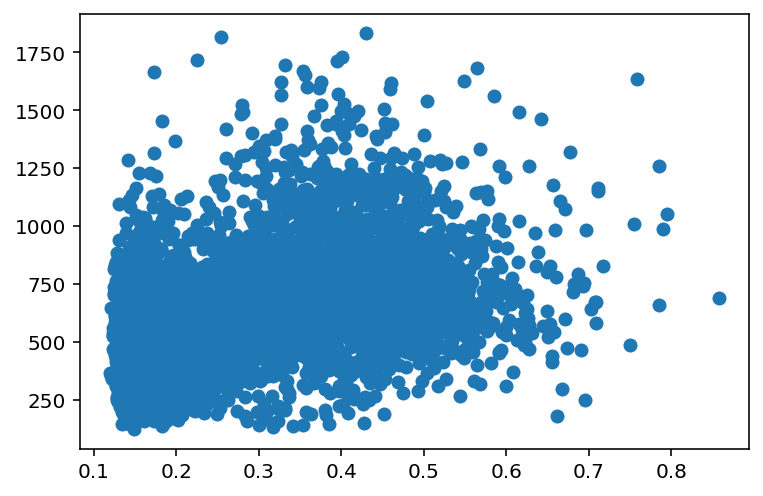

In [ ]:
# example: showing the relationship of nuclei with HCR measurements and properties of the nucleus.

plt.scatter(test.HCR_measurements.Rd2_CY3_mean_intensity,test.HCR_measurements.Rd1_CY5_filled_area)


(array([  4.,  10.,  18.,  29.,  50.,  76.,  87., 142., 139., 199., 172.,
        214., 189., 185., 182., 157., 127., 103.,  62.,  47.,  31.,  32.,
         21.,  12.,  13.,   9.,   9.,   6.,   3.,   1.,   1.,   1.,   1.,
          0.,   1.,   0.,   1.,   0.,   1.,   1.]),
 array([ 8.54400375, 10.07843826, 11.61287278, 13.1473073 , 14.68174181,
        16.21617633, 17.75061085, 19.28504536, 20.81947988, 22.3539144 ,
        23.88834892, 25.42278343, 26.95721795, 28.49165247, 30.02608698,
        31.5605215 , 33.09495602, 34.62939053, 36.16382505, 37.69825957,
        39.23269409, 40.7671286 , 42.30156312, 43.83599764, 45.37043215,
        46.90486667, 48.43930119, 49.9737357 , 51.50817022, 53.04260474,
        54.57703926, 56.11147377, 57.64590829, 59.18034281, 60.71477732,
        62.24921184, 63.78364636, 65.31808087, 66.85251539, 68.38694991,
        69.92138443]),
 <a list of 40 Patch objects>)

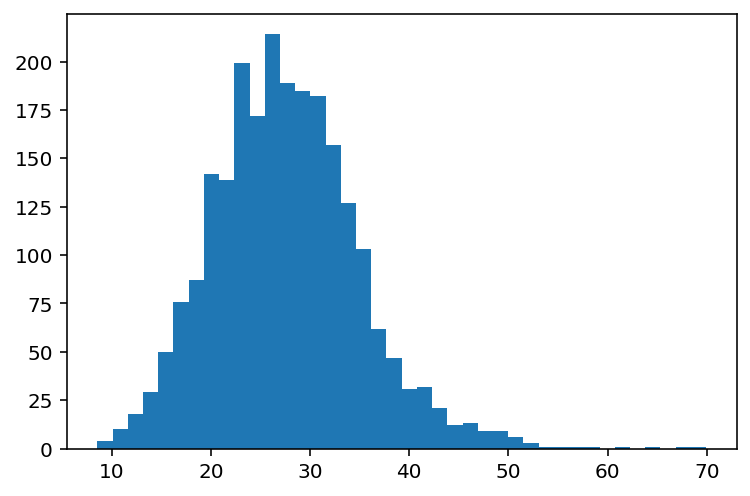

In [ ]:
plt.hist(test.timelapse_nucPhase_features[0]["phase_feret_diameter_max"],bins=40)

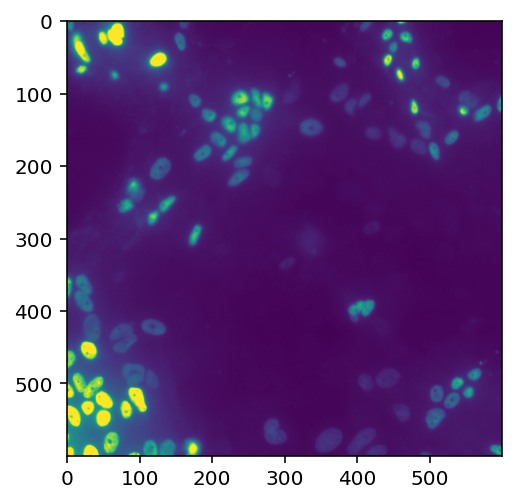

In [ ]:
# show image of HCR

plt.imshow(test.HCR_Rd2_images[1][1000:1600,1000:1600])

In [ ]:
test.timelapse_phase_images

[array([[0.47645973, 0.48584308, 0.51205688, ..., 0.45441631, 0.53275983,
         0.52620638],
        [0.50073729, 0.4855452 , 0.47914069, ..., 0.52844051, 0.51592937,
         0.50967381],
        [0.48658779, 0.49358807, 0.49999257, ..., 0.51563149, 0.52412119,
         0.52322754],
        ...,
        [0.50863121, 0.51667408, 0.53201512, ..., 0.4582888 , 0.42105329,
         0.46722532],
        [0.50580131, 0.5266532 , 0.51563149, ..., 0.43937316, 0.45396948,
         0.47005522],
        [0.49522643, 0.5163762 , 0.53201512, ..., 0.43401124, 0.42686203,
         0.46037399]]),
 array([[0.51460976, 0.50531972, 0.5033718 , ..., 0.52015382, 0.50472036,
         0.50876602],
        [0.49902646, 0.47550167, 0.49018594, ..., 0.52749595, 0.47834862,
         0.51086377],
        [0.49288304, 0.50546955, 0.48958658, ..., 0.50007534, 0.49692871,
         0.49572999],
        ...,
        [0.55191977, 0.52165221, 0.52195189, ..., 0.45841998, 0.43789198,
         0.45332544],
        [0.5